In [ ]:
# Uncomment to install the required packages
# !pip install git+https://github.com/fagonzalezo/kdm.git@generative

In [2]:
import numpy as np
from scipy.stats import norm
from scipy.stats import gaussian_kde

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import ModelCheckpoint


from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from kdm.models import KDMDenEstModel, KDMClassModel, KDMJointDenEstModel
import kdm

from tqdm import tqdm

import matplotlib.pyplot as plt

## 1 Generative classification two moons

The following example illustrates the use of the inference process using a generative classification model.

In general, the KDM classification model minimizes the following lost function:

$$
L(x^{(i)}, y^{(i)}) = - \sum_{k=1}^K 1(y^{(i)} == k) \log  P(y=k | x^{(i)}) - \alpha \log P(x^{(i)})
$$

Both $P(y=k | x^{(i)})$ and $P(x^{(i)})$ are predictions of the KDM model. $\alpha$ controls the importance of the generative component of the loss.

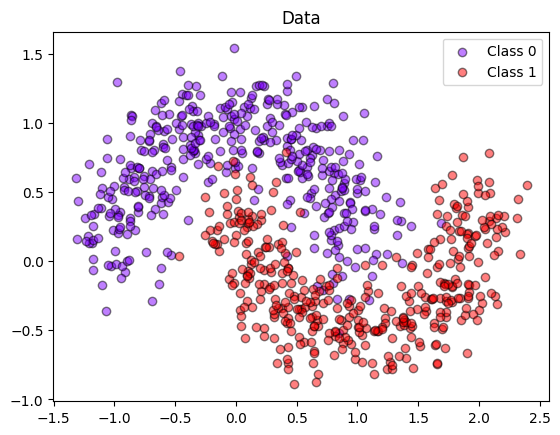

In [3]:
# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    plt.contourf(XX, YY, ZZ, 100, cmap = plt.cm.coolwarm, vmin= 0, vmax=1)
    plt.colorbar()
    CS = plt.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    plt.clabel(CS, inline=1, fontsize=10)
    plt.xlabel("x")
    plt.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

def gen_pred_fun_reg(clf):
    def pred_fun(X):
        return clf.predict(X)
    return pred_fun

# Create a 2 moons dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

plot_data(X_train, y_train)

We use the KDMClassModel to train a shallow model that directly apply a KDM inference layer to the raw data. This class assumes a continuos distribution for the input data (i.e. it uses an RBF kernel) and a discrete distribution for the output data. The `generative` parameter corresponds to the $\alpha$ parameter controllin the importance of the generative term of the loss function.

In [4]:
encoded_size = 2
dim_y = 2
encoder = keras.Sequential([keras.layers.Identity()])
n_comp = 30

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.05,
                            generative=1.)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=keras.losses.sparse_categorical_crossentropy,
                    metrics=[metrics.sparse_categorical_accuracy])
kdm_model.predict(X_train[:10])
idx = np.random.randint(X_train.shape[0], size=n_comp)
kdm_model.init_components(X_train[idx],
                          np.eye(2)[y_train[idx]],
                          init_sigma=False)

kdm_model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 11.1324 - sparse_categorical_accuracy: 0.7604 
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6650 - sparse_categorical_accuracy: 0.9275 
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0479 - sparse_categorical_accuracy: 0.9524 
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8952 - sparse_categorical_accuracy: 0.9559 
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8231 - sparse_categorical_accuracy: 0.9654 
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7612 - sparse_categorical_accuracy: 0.9691 
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7580 - sparse_categorical_accuracy: 0.9569 
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7317 - sparse_categorical_accuracy: 0.9691 
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7480 - sparse_categorical_accu

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test loss: 5.75390625
Test accuracy: 0.9750000238418579
Sigma: 0.2924405336380005


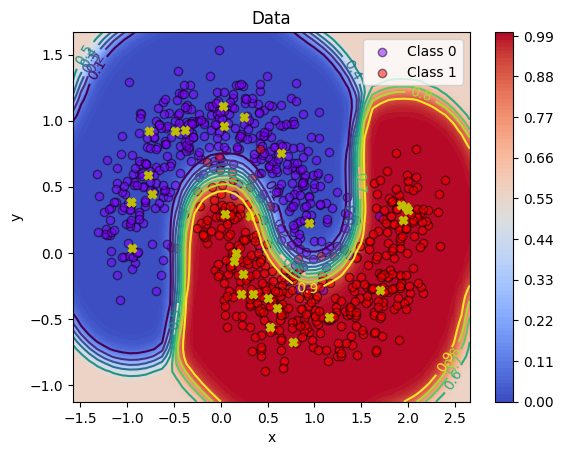

In [5]:
# Plot the decision region
plot_decision_region(X, gen_pred_fun(kdm_model))
plot_data(X_train, y_train)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

The KDM components are shown as yellow crosses. Each component has two elements, an $x$ part and a $y$ part. The components are listed below:

In [6]:
weights = np.abs(kdm_model.kdm.c_w.numpy())
weights /= np.sum(weights)
idx = np.argsort(weights)[::-1]
for i in range(kdm_model.n_comp):
    print(f'Component {i}')
    print(f' Weight: {weights[idx[i]]}')
    print(f' x: {kdm_model.kdm.c_x[idx[i]].numpy()}')
    print(f' y: {kdm_model.kdm.c_y[idx[i]].numpy()}')


Component 0
 Weight: 0.10160686820745468
 x: [0.6480368 0.7517459]
 y: [1. 0.]
Component 1
 Weight: 0.10092119127511978
 x: [ 1.7002733 -0.2781769]
 y: [0. 1.]
Component 2
 Weight: 0.08912298828363419
 x: [0.93674767 0.22931436]
 y: [1. 0.]
Component 3
 Weight: 0.07493914663791656
 x: [ 1.1537364  -0.48202613]
 y: [0. 1.]
Component 4
 Weight: 0.06330017745494843
 x: [0.04514575 0.2950173 ]
 y: [0. 1.]
Component 5
 Weight: 0.06240705028176308
 x: [ 0.60269314 -0.4207785 ]
 y: [0. 1.]
Component 6
 Weight: 0.054260749369859695
 x: [0.03003578 0.9569061 ]
 y: [1. 0.]
Component 7
 Weight: 0.05133352801203728
 x: [1.9448855  0.24454248]
 y: [0. 1.]
Component 8
 Weight: 0.05065883696079254
 x: [-0.3793115  0.9305135]
 y: [1. 0.]
Component 9
 Weight: 0.04071652144193649
 x: [-0.77282465  0.5871294 ]
 y: [1. 0.]
Component 10
 Weight: 0.038783252239227295
 x: [0.24579044 1.0240563 ]
 y: [1. 0.]
Component 11
 Weight: 0.03504538908600807
 x: [-0.48769018  0.9211423 ]
 y: [1. 0.]
Component 12
 Weig

## 2 Generative classification with overlapping classes

In this example we want to see if the learned prototypes can capture the continous variation from one class to the other.

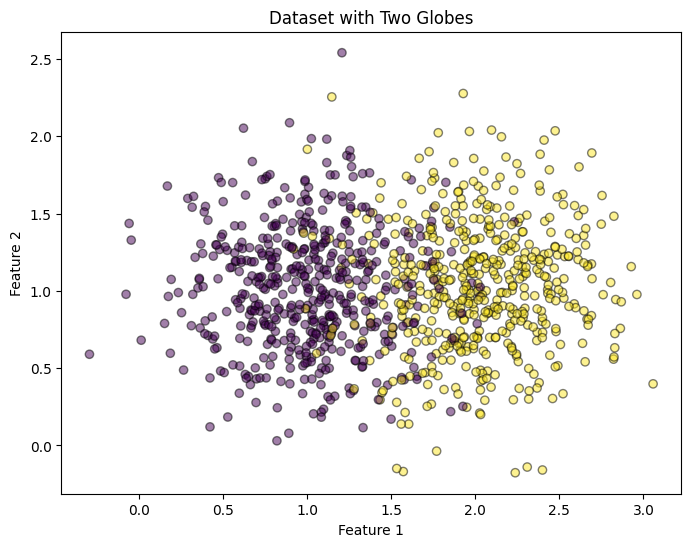

In [7]:
from sklearn.datasets import make_blobs

# Create a dataset with two blobs located at (1, 1) and (2, 1)
centers = [(1, 1), (2, 1)]
X_blobs, y_blobs = make_blobs(n_samples=1000, centers=centers, cluster_std=0.4, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap='viridis', alpha=0.5, edgecolor='k')
plt.title("Dataset with Two Globes")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

y_blobs_ohe = keras.utils.to_categorical(y_blobs)
# scale y_blobs to be in the range [0.1, 0.9]
y_blobs = (y_blobs - np.min(y_blobs)) / (np.max(y_blobs) - np.min(y_blobs)) * 0.8 + 0.1
y_blobs_ohe = (y_blobs_ohe - np.min(y_blobs_ohe)) / (np.max(y_blobs_ohe) - np.min(y_blobs_ohe)) * 0.8 + 0.1



Here we train a generative model as before, but we keep the sigma fixed, so that protoypes distribute evenly through the space where the training samples are.

In [8]:
encoded_size = 2
dim_y = 2
encoder = keras.Sequential([keras.layers.Identity()])
n_comp = 30

kdm_model = KDMClassModel(encoded_size=encoded_size,
                            dim_y=dim_y,
                            encoder=encoder,
                            n_comp=n_comp,
                            sigma=0.1,
                            sigma_trainable=False,
                            generative=1.)

# train the classifier
kdm_model.compile(optimizer=optimizers.Adam(learning_rate=5e-3),
                    loss=keras.losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])
#kdm_model.predict(X_train[:10])
idx = np.random.randint(X_blobs.shape[0], size=n_comp)
kdm_model.init_components(X_blobs[idx],
                          y_blobs_ohe[idx],
                          init_sigma=False)

kdm_model.fit(X_blobs, y_blobs_ohe, epochs=10, batch_size=32, verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - categorical_accuracy: 0.8458 - loss: 8.2912
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8650 - loss: 7.7004 
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8858 - loss: 7.2675 
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8799 - loss: 7.2296 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8967 - loss: 7.2249 
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8854 - loss: 7.1354 
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8878 - loss: 7.0802 
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.8874 - loss: 7.1997 
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9034 - loss: 7.0592 
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - categorical_accuracy: 0.9043 - loss:

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test loss: 7.05866813659668
Test accuracy: 0.8960000276565552
Sigma: 0.10000000149011612


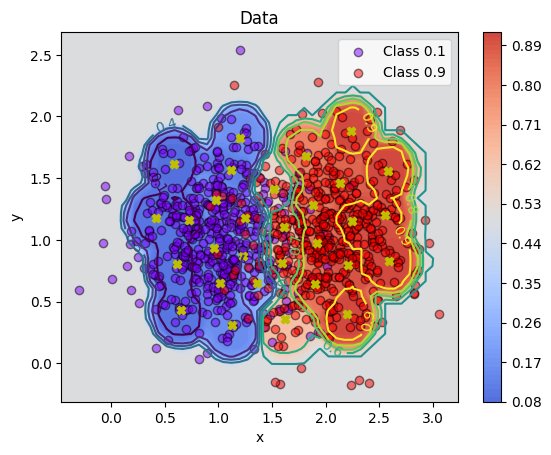

In [9]:
# Plot the decision region
plot_decision_region(X_blobs, gen_pred_fun(kdm_model))
plot_data(X_blobs, y_blobs)
# plot the prototypes
plt.scatter(kdm_model.kdm.c_x.numpy()[:, 0], kdm_model.kdm.c_x.numpy()[:, 1], c='y', marker='X')
# Evaluate the classifier
score = kdm_model.evaluate(X_blobs, y_blobs_ohe, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(f'Sigma: {kdm_model.kernel.sigma.numpy()}')

As we can see that the prototypes are in fact evenly distributed. Since the classes are overlapping, we want to check how the $y$ component of the prototypes varies when we move from one class to the other. The following figure plots the $x$ component of the prototypes against the probability encoded by the $y$ component.

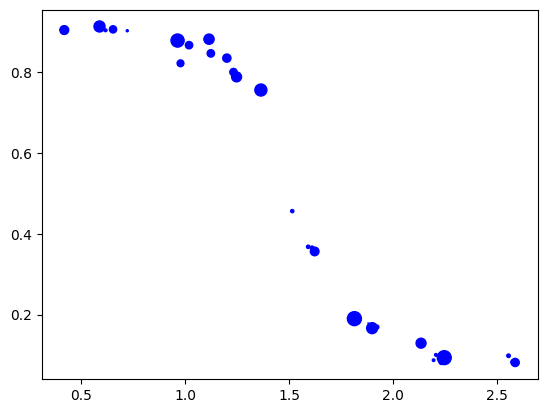

In [10]:
ys  = kdm_model.kdm.c_y.numpy()
ys = keras.utils.normalize(ys, order=2, axis=-1) ** 2
xs = kdm_model.kdm.c_x.numpy()[:, 0]
# plot the prototypes with circles with size proportional to the weights
plt.scatter(xs, ys[:, 0], c='b', marker='o', s=weights*1000)


# 3 Generative image classification

We train a generative image classifier based on KDM. The dataset is a synthetic image classifier available at https://www.kaggle.com/datasets/gonzalorecioc/color-polygon-images. The images in the dataset correspond to polygons with different sizes, locations and colors. The dataset can be used for different classification and regression tasks. Here we will address a regression task, to estimate the radius of the enclosing circle of the polygon. However, we will address it as a classification task to see if the learned prototypes are able to capture the continuos nature of the underlining problem.

In [11]:
# Download dataset
# https://www.kaggle.com/datasets/gonzalorecioc/color-polygon-images
# You have to upload your Kaggle api key: https://www.kaggle.com/docs/api#authentication

#! pip install -q kaggle
#from google.colab import files
#files.upload()
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#
#import kagglehub
#
# Download latest version
#path = kagglehub.dataset_download("gonzalorecioc/color-polygon-images")
#
#print("Path to dataset files:", path)

Saving kaggle.json to kaggle.json


100%|██████████| 8.00M/8.00M [00:01<00:00, 5.80MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gonzalorecioc/color-polygon-images/versions/1


In [12]:
# to run this example download the data from
# and set the paths accordingly
# path = "/Users/fgonza/Documents/research/code/data/color_poly_images/"
targets_path = path + "/targets.csv"
images_path = path + "/images/content/images/"

In [13]:
print(targets_path)
print(images_path)

/root/.cache/kagglehub/datasets/gonzalorecioc/color-polygon-images/versions/1/targets.csv
/root/.cache/kagglehub/datasets/gonzalorecioc/color-polygon-images/versions/1/images/content/images/


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the targets.csv file
targets_df = pd.read_csv(targets_path)

# split the data into train and test
train_df, test_df = train_test_split(targets_df, test_size=0.2, random_state=42)

# Print the maximum and minumum values of bound_circle_r column
print(f"Maximum bound_circle_r: {train_df['bound_circle_r'].max()}")
print(f"Minimum bound_circle_r: {train_df['bound_circle_r'].min()}")

Maximum bound_circle_r: 66
Minimum bound_circle_r: 10


In [15]:
import tensorflow as tf
import pandas as pd

def preprocess_image(image_path):
    """
    Loads an image from the given path and preprocesses it for the dataset.

    Args:
        image_path (str): The file path to the image.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to a fixed size (e.g., 224x224)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32 and normalize
    image = image / 255.0
    return image

def create_tf_dataset(dataframe, target_column='rotation',
                      batch_size=32, image_folder_path='',
                      shuffle=True):
    """
    Converts a Pandas DataFrame into a TensorFlow dataset for image classification.

    Args:
        dataframe (pd.DataFrame): The input DataFrame containing image filenames and target labels.
        target_column (str, optional): The column name in the DataFrame representing the target labels.
                                       Defaults to 'rotation'.
        batch_size (int, optional): The batch size for the dataset. Defaults to 32.
        image_folder_path (str, optional): The path to the folder containing the images. Defaults to ''.
        shuffle (bool, optional): Whether to shuffle the dataset. Defaults to True.

    Returns:
        tf.data.Dataset: A TensorFlow dataset with preprocessed images and corresponding labels.
                           Images are loaded, resized, and normalized.
                           Target labels are scaled to a range between 0.1 and 0.9.
    """
    # Drop the 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in dataframe.columns:
        dataframe = dataframe.drop(columns=['Unnamed: 0'])

    # Append image folder path to filenames
    image_paths = [image_folder_path + '/' +  filename for filename in dataframe['filename'].values]
    target = dataframe[target_column].values / 70.# Normalize the target values
    # make target binary label
    target = (target > 0.5).astype(int)
    # make target a ohe
    target = keras.utils.to_categorical(target, num_classes=2)

    # Scale the target to [0.1, 0.9]
    target = (target - np.min(target)) / (np.max(target) - np.min(target)) * 0.8 + 0.1

    # Create a TensorFlow dataset from image paths and targets
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, target))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe))  # Shuffle if shuffle=True

    dataset = (dataset
                .map(lambda path, label: (preprocess_image(path), label),
                     num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE))

    return dataset

In [16]:
import tensorflow as tf

train_ds = create_tf_dataset(train_df, target_column='bound_circle_r',
                             batch_size=128, image_folder_path=images_path)

test_ds = create_tf_dataset(test_df, target_column='bound_circle_r',
                            batch_size=32, image_folder_path=images_path)


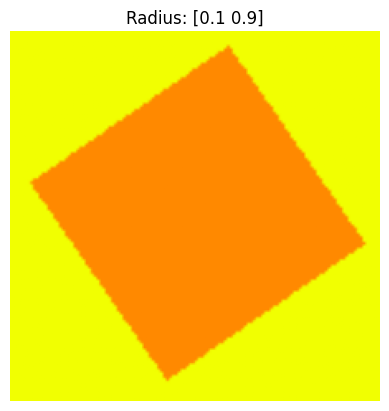

1.0 0.0
(224, 224, 3)


In [17]:
# read an image from the dataset and plot it
for image, label in train_ds.take(1):
    plt.imshow(image[0])
    plt.title(f"Radius: {label[0].numpy()}")
    plt.axis('off')
    plt.show()
    print(np.max(image[0].numpy()), np.min(image[0].numpy()))
    print(image[0].shape)

In [18]:
def create_encoder(input_shape, hidden_size, encoded_size):
    """
    Creates an encoder model using a pre-trained MobileNetV2 model.

    Args:
        input_shape (tuple): The shape of the input tensor.
        base_depth (int): The depth of the base model.
        encoded_size (int): The size of the encoded representation.

    Returns:
        keras.Model: The encoder model.
    """
    base_model = keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(hidden_size, activation=keras.activations.relu)(x)
    outputs = keras.layers.Dense(encoded_size)(x)

    encoder = keras.Model(inputs, outputs, name='encoder')
    return encoder


def run_experiment(encoded_size=10,
                   n_comp=64,
                   sigma_mult=0.2,
                   epochs=10,
                   batch_size=128):

    encoder = create_encoder(input_shape=(224, 224, 3), hidden_size=64, encoded_size=encoded_size)
    print(encoder.summary())
    # warm up the encoder with a small subset
    encoder_wmp = keras.Sequential([encoder,
                                    keras.layers.Dense(2, activation='softmax')])
    encoder_wmp.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                    loss=losses.categorical_crossentropy,
                    metrics=[metrics.categorical_accuracy])

    # train the encoder for 1 epoch
    subset_ds = train_ds
    encoder_wmp.fit(subset_ds, epochs=1, verbose=1)

    # Create a KDM classifier model

    kdm_disc = KDMClassModel(encoded_size=encoded_size,
                                dim_y=2,
                                encoder=encoder,
                                n_comp=n_comp,
                                sigma=1.0,
                                w_train=True)

    # initialize the prototypes using random sample from train_ds
    init_prot_x = []
    init_prot_y = []
    for image, label in train_ds.unbatch().take(n_comp):
        init_prot_x.append(image[None, ...])
        init_prot_y.append(label)
    init_prot_x = np.concatenate(init_prot_x, axis=0)
    print(init_prot_x.shape)
    init_prot_y = np.array(init_prot_y)
    kdm_disc.init_components(init_prot_x, init_prot_y,
                            init_sigma=True, sigma_mult=sigma_mult)
    print(f"Sigma: {kdm_disc.kdm.kernel.sigma.numpy()}")
    # Compile the model
    kdm_disc.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
                        loss=losses.categorical_crossentropy,
                        metrics=[metrics.categorical_accuracy])

    # Callback to save the best model
    checkpoint = keras.callbacks.ModelCheckpoint('best_model.weights.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True)

    # train the classifier
    #kdm_disc.predict(X_train[:10])
    history = kdm_disc.fit(train_ds,
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[checkpoint],
                  validation_data=test_ds,
                  verbose=1)

    kdm_disc.load_weights('best_model.weights.h5')

    # Evaluate the classifier
    score = kdm_disc.evaluate(test_ds, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    score = kdm_disc.evaluate(train_ds, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    print(f'Sigma: {kdm_disc.kernel.sigma.numpy()}')

    return kdm_disc, history


In [19]:
kdm_disc_1, history = run_experiment(encoded_size=10,
                                   n_comp=64,
                                   sigma_mult=0.5,
                                   epochs=1,
                                   batch_size=128)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,340,618 (8.93 MB)

 Trainable params: 2,306,506 (8.80 MB)

 Non-trainable params: 34,112 (133.25 KB)

None
63/63 ━━━━━━━━━━━━━━━━━━━━ 118s 775ms/step - categorical_accuracy: 0.8855 - loss: 0.5178
(64, 224, 224, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Sigma: 4.070001602172852
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 624ms/step - categorical_accuracy: 0.9142 - loss: 0.5159 - val_categorical_accuracy: 0.9845 - val_loss: 0.3430
Test loss: 0.34303128719329834
Test accuracy: 0.984499990940094
Train loss: 0.33959251642227173
Train accuracy: 0.9891250133514404
Sigma: 4.071652889251709


In [20]:
def run_experiment_gen(encoded_size=10,
                   n_comp=64,
                   sigma_mult=0.2,
                   sigma_trainable=False,
                   epochs=10,
                   batch_size=128,
                   kdm_disc=None):

    encoder = create_encoder(input_shape=(224, 224, 3), hidden_size=64, encoded_size=encoded_size)
    encoder.set_weights(kdm_disc.encoder.get_weights())

    # Create a KDM classifier model

    kdm_gen = KDMClassModel(encoded_size=encoded_size,
                                dim_y=2,
                                encoder=encoder,
                                n_comp=n_comp,
                                sigma=kdm_disc.kernel.sigma.numpy() * sigma_mult,
                                sigma_trainable=sigma_trainable,
                                w_train=True,
                                generative=1.0)

    # initialize the prototypes using random sample from train_ds
    init_prot_x = []
    init_prot_y = []
    for image, label in train_ds.unbatch().take(n_comp):
        init_prot_x.append(image[None, ...])
        init_prot_y.append(label)
    init_prot_x = np.concatenate(init_prot_x, axis=0)
    print(init_prot_x.shape)
    init_prot_y = np.array(init_prot_y)
    kdm_gen.init_components(init_prot_x, init_prot_y,
                            init_sigma=False)
    print(f"Sigma: {kdm_gen.kdm.kernel.sigma.numpy()}")
    # Compile the model
    kdm_gen.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                        loss=losses.categorical_crossentropy,
                        metrics=[metrics.categorical_accuracy])

    # Callback to save the best model
    checkpoint = keras.callbacks.ModelCheckpoint('best_model_gen.weights.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True)

    # train the classifier
    history = kdm_gen.fit(train_ds,
                  epochs=epochs,
                  batch_size=batch_size,
                  callbacks=[checkpoint],
                  validation_data=test_ds,
                  verbose=1)

    kdm_gen.load_weights('best_model_gen.weights.h5')

    # Evaluate the classifier
    score = kdm_gen.evaluate(test_ds, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    score = kdm_gen.evaluate(train_ds, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    print(f'Sigma: {kdm_gen.kernel.sigma.numpy()}')

    return kdm_gen, history


In [85]:
kdm_gen_1, history = run_experiment_gen(encoded_size=10,
                                      n_comp=128,
                                      sigma_mult=0.2,
                                      epochs=50,
                                      batch_size=128,
                                      kdm_disc=kdm_disc_1)

(128, 224, 224, 3)
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Sigma: 0.8143305778503418
Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - categorical_accuracy: 0.9597 - loss: 28.0771 - val_categorical_accuracy: 0.9705 - val_loss: 27.7578
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - categorical_accuracy: 0.9651 - loss: 27.8327 - val_categorical_accuracy: 0.9710 - val_loss: 27.6568
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - categorical_accuracy: 0.9634 - loss: 27.8009 - val_categorical_accuracy: 0.9720 - val_loss: 27.6123
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - categorical_accuracy: 0.9662 - loss: 27.6477 - val_categorical_accuracy: 0.9730 - val_loss: 27.6292
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - categorical_accuracy: 0.9682 - loss: 27.6329 - val_categorical_accuracy: 0.9740 - val_loss: 27.5828
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - categorical_accuracy: 0.9658 - loss: 27.7371 - val_categorical_accuracy: 0.9755 - val_loss: 27.58

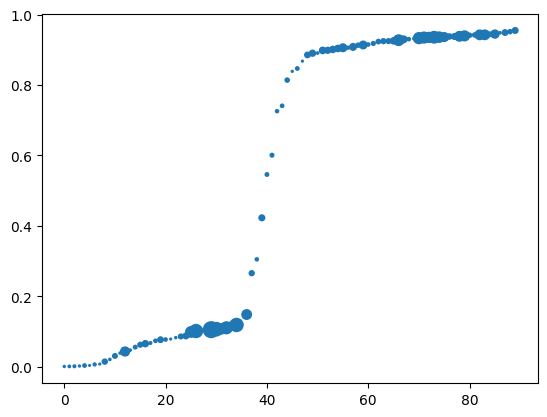

In [86]:
# plot y prototypes
xs = kdm_gen_1.kdm.c_x.numpy()
ys = kdm_gen_1.kdm.c_y.numpy() / np.linalg.norm(kdm_gen_1.kdm.c_y.numpy(), axis=1, keepdims=True)
ys = ys ** 2
weights = np.abs(kdm_gen_1.kdm.c_w.numpy())
weights /= np.sum(weights)

# select 70% prototypes with largest weights
idx = np.argsort(weights)[int(weights.shape[0] * 0.3):]

sorted_xs = xs[idx]
sorted_ys = ys[idx, 1]
sorted_weights = weights[idx]

idx = np.argsort(sorted_ys)

sorted_xs = sorted_xs[idx]
sorted_ys = sorted_ys[idx]
sorted_weights = sorted_weights[idx]

plt.scatter(np.arange(len(sorted_ys)), sorted_ys, s=sorted_weights*2000)

# create prototypes_df using sorted xs, ys and weights
prototypes_df = pd.DataFrame({'x': None,  'y':sorted_ys, 'w': sorted_weights})

for i in range(sorted_xs.shape[0]):
    prototypes_df.at[i, 'x'] = sorted_xs[i]

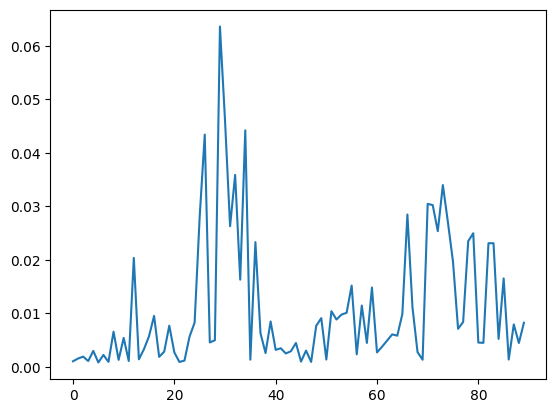

In [87]:
plt.plot(sorted_weights)

In [88]:
print(kdm_gen_1.kdm.kernel.sigma.numpy())

0.8143306


In [89]:
encoded_size = 10
encoder_1 = create_encoder(input_shape=(224, 224, 3), hidden_size=64, encoded_size=encoded_size)
encoder_1.set_weights(kdm_disc_1.encoder.get_weights())

train_ds_noshuf = create_tf_dataset(train_df, target_column='bound_circle_r',
                             batch_size=128, image_folder_path=images_path,
                                    shuffle=False)



In [90]:
# prompt: Encode the images in train_ds_noshuf.
# Create a copy of train_df and add the encoding vector as a new column.

# Encode the images in train_ds_noshuf
encoded_images = encoder_1.predict(train_ds_noshuf)

# Create a copy of train_df
train_df_encoded = train_df.copy()

#reset indices
train_df_encoded.reset_index(drop=True, inplace=True)

# Add the encoding vector as a new column
train_df_encoded['encoding'] = encoded_images.tolist()

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step


In [96]:
# prompt: Use sklearn to find the k-nearest neighbors of each prototype in prototypes_df. in encoded images.
# Store the indices of the nn as a list in a column of a  prototypes_df.

from sklearn.neighbors import NearestNeighbors

# Assuming 'prototypes_df' and 'encoded_images' are defined as in your provided code

# Create a NearestNeighbors model with k=5 (you can adjust k as needed)
knn_model = NearestNeighbors(n_neighbors=20)

# Fit the model on the encoded images
knn_model.fit(encoded_images)

# Find the k-nearest neighbors for each prototype in prototypes_df
prototype_encodings = np.array([x for x in prototypes_df['x'].values])
distances, indices = knn_model.kneighbors(prototype_encodings)

# Store the indices of the nearest neighbors as a list in a new column 'nn_indices'
prototypes_df['nn_indices'] = indices.tolist()

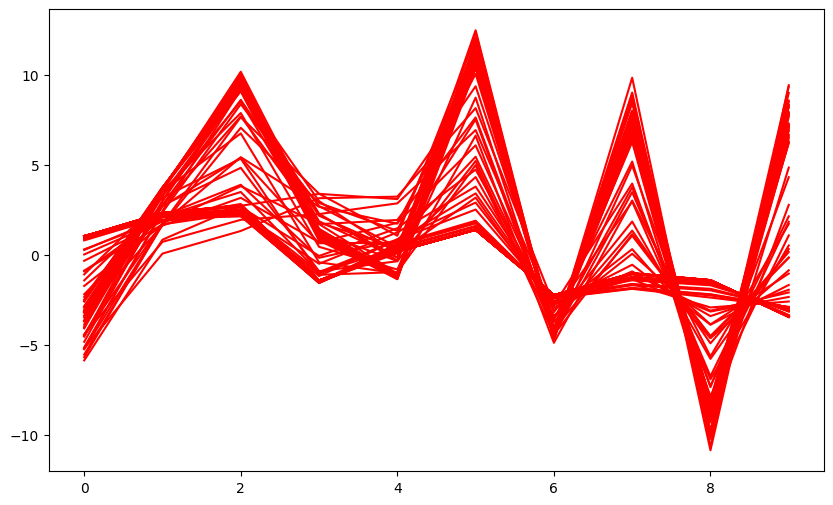

In [97]:
# prompt: Plot the encoding vectors of the nn of a given prototype, along with the x vector of the prototype

import matplotlib.pyplot as plt

# Assuming prototypes_df and train_df_encoded are defined as in your code

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

for index, row in prototypes_df.iterrows():
    prototype_encoding = row['x']


    # Plot the prototype's encoding vector
    plt.plot(np.arange(len(prototype_encoding)), prototype_encoding, color='red', label='Prototype Encoding')
plt.show()

In [98]:
# prompt: For each prototype, calculate the average and std deviation of the bound_circle_r attribute of the nearest neighbors

# Assuming prototypes_df and train_df_encoded are defined as in your code

# Calculate average and std deviation of 'bound_circle_r' for nearest neighbors
prototypes_df['nn_bound_circle_r_avg'] = 0.0
prototypes_df['nn_bound_circle_r_std'] = 0.0

for index, row in prototypes_df.iterrows():
    nn_indices = row['nn_indices']
    nn_bound_circle_r = train_df_encoded.iloc[nn_indices]['bound_circle_r'].values
    prototypes_df.at[index, 'nn_bound_circle_r_avg'] = np.mean(nn_bound_circle_r)
    prototypes_df.at[index, 'nn_bound_circle_r_std'] = np.std(nn_bound_circle_r)

print(prototypes_df[['nn_bound_circle_r_avg', 'nn_bound_circle_r_std']])

    nn_bound_circle_r_avg  nn_bound_circle_r_std
0                   50.75               5.097794
1                   15.80               4.118252
2                   22.90               3.207803
3                   21.10               4.493328
4                   22.10               4.846648
..                    ...                    ...
85                  52.60               4.066940
86                  42.70               7.315053
87                  53.05               4.140954
88                  37.15               0.909670
89                  54.15               5.265691

[90 rows x 2 columns]


In [99]:
# prompt: Create a copy of prototypes_df with those prototypes on the top 50% percentile of the weights, column 'w'

# Calculate the 50th percentile of the 'w' column
percentile = prototypes_df['w'].quantile(0.2)

# Create a copy of prototypes_df with prototypes above the 50th percentile
prototypes_df_top = prototypes_df[prototypes_df['w'] >= percentile].copy()

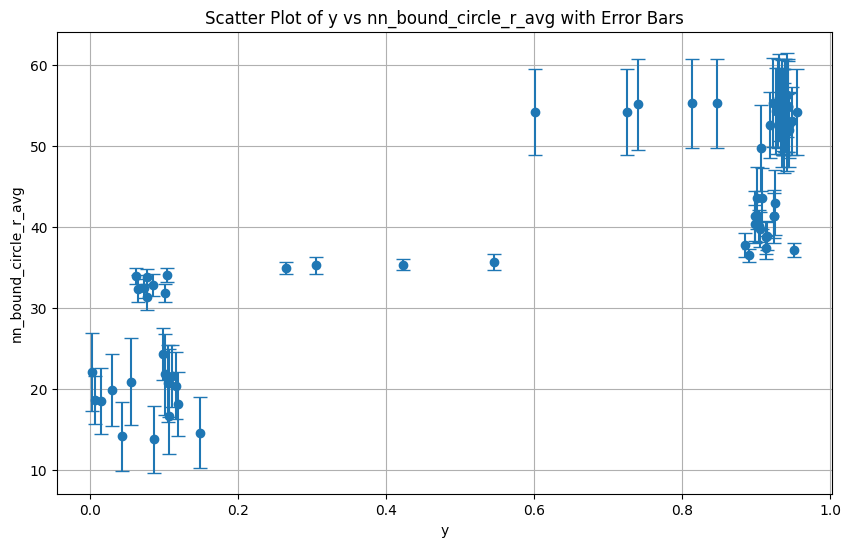

In [100]:
# prompt: Make a scatter plot of the y column vs nn_bound_circle_r_avg column using nn_bound_circle_r_std as error bars

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.errorbar(prototypes_df_top['y'], prototypes_df_top['nn_bound_circle_r_avg'],
             yerr=prototypes_df_top['nn_bound_circle_r_std'], fmt='o', capsize=5)
plt.xlabel('y')
plt.ylabel('nn_bound_circle_r_avg')
plt.title('Scatter Plot of y vs nn_bound_circle_r_avg with Error Bars')
plt.grid(True)
plt.show()